In [264]:
import pickle
import numpy as np
import os
import torch
import torch.nn as nn
import re
import sys
from tensorboard.backend.event_processing.event_accumulator import EventAccumulator
import matplotlib.pyplot as plt

root = os.path.dirname(os.path.abspath(os.curdir))
sys.path.append(root)

from sr_model.models.models import AnalyticSR, STDP_SR, Linear, MLP
from datasets import inputs, sf_inputs_discrete
from run_td_rnn import run as run_rnn
from run_td_mlp import run as run_mlp
from run_td_linear import run as run_linear
from utils import get_firing_field
import configs

device = 'cpu'

# Specify dataset and run network

In [215]:
num_states = 14*14

In [243]:
# One hot
feature_maker_kwargs = {
    'feature_dim': num_states, 'feature_type': 'nhot'
    }

# Correlated inputs
feature_maker_kwargs = {
    'feature_dim': num_states, 'feature_vals': None,
    'feature_vals_p': [0.99, 0.01],
    'feature_type': 'correlated_distributed',
    'spatial_sigma': 1.25, 'seed_generation': 3
    }

num_steps = 6000

# Regular dataset
reg_dataset_config = {
    'num_steps': num_steps, 'num_states': num_states,
    'feature_maker_kwargs': feature_maker_kwargs,
    'barriers': None
    }
reg_dataset = sf_inputs_discrete.Sim2DWalk

# Barrier dataset
barrier_dataset_config = {
    'num_steps': num_steps, 'num_states': num_states,
    'feature_maker_kwargs': feature_maker_kwargs,
    'barriers': 'transitions'
    }
barrier_dataset = sf_inputs_discrete.Sim2DWalk

input_size = feature_maker_kwargs['feature_dim']

In [244]:
# Are feature maps the same across walks?
a = barrier_dataset(**barrier_dataset_config)
b = reg_dataset(**reg_dataset_config)
not np.any(a.feature_maker.feature_map != b.feature_maker.feature_map)

True

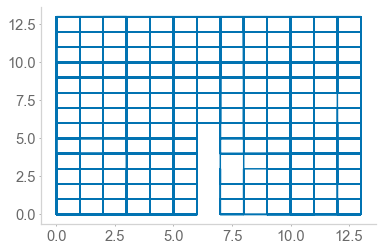

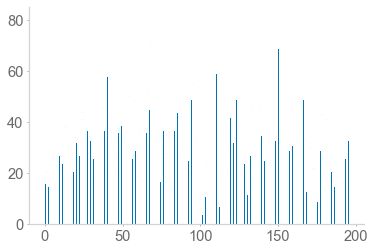

29.0


0.0

In [245]:
input = barrier_dataset(**barrier_dataset_config)
plt.figure();
plt.plot(input.xs, input.ys)
plt.show()

plt.figure();
states = np.argwhere(input.state_inputs)[:,0]
counts = np.zeros(input.num_states)
for state in np.arange(input.num_states):
    counts[state] = np.sum(states==state)
plt.bar(np.arange(input.num_states), counts)
plt.show()
print(np.median(counts))
np.sum(counts == 0)/input.num_states

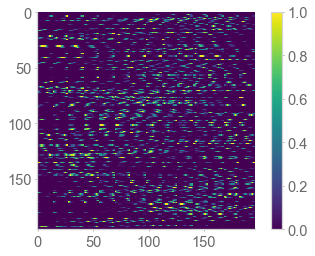

0.07372606997473134


In [246]:
plt.figure()
plt.imshow(input.feature_maker.feature_map, cmap='viridis')
plt.colorbar()
plt.show()
print(np.sum(input.feature_maker.feature_map)/input.feature_maker.feature_map.size)

In [247]:
gamma=0.98

In [248]:
arena_length = int(np.sqrt(input.num_states)) - 1
walk_xs = input.xs.astype(int)
walk_ys = input.ys.astype(int)

# Main Option: Use RNN

In [249]:
rnn = AnalyticSR(
    num_states=input_size, gamma=gamma,
    ca3_kwargs={
        'use_dynamic_lr':False, 'lr':1E-3,
        'rollout':10, 'alpha': 2., 'beta': 2.
        }
    )

reg_outputs, loss, reg_dset = run_rnn(
    '../trained_models/test/', rnn, reg_dataset,
    reg_dataset_config, gamma=gamma, test_over_all=False,
    train_net=False, return_dset=True
    )
rnn.reset()
barrier_outputs, loss, barrier_dset = run_rnn(
    '../trained_models/test/', rnn, barrier_dataset,
    barrier_dataset_config, gamma=gamma, test_over_all=False,
    train_net=False, return_dset=True
    )


[   51] loss: 0.036
Time per step 0.004s, net 0.192s

[  101] loss: 0.038
Time per step 0.004s, net 0.402s

[  151] loss: 0.039
Time per step 0.004s, net 0.619s

[  201] loss: 0.038
Time per step 0.004s, net 0.833s

[  251] loss: 0.038
Time per step 0.004s, net 1.054s

[  301] loss: 0.038
Time per step 0.004s, net 1.275s

[  351] loss: 0.038
Time per step 0.004s, net 1.486s

[  401] loss: 0.038
Time per step 0.004s, net 1.703s

[  451] loss: 0.037
Time per step 0.004s, net 1.922s

[  501] loss: 0.038
Time per step 0.004s, net 2.133s

[  551] loss: 0.038
Time per step 0.005s, net 2.360s

[  601] loss: 0.037
Time per step 0.005s, net 2.598s

[  651] loss: 0.037
Time per step 0.004s, net 2.802s

[  701] loss: 0.038
Time per step 0.004s, net 3.015s

[  751] loss: 0.038
Time per step 0.004s, net 3.215s

[  801] loss: 0.039
Time per step 0.005s, net 3.490s

[  851] loss: 0.039
Time per step 0.004s, net 3.701s

[  901] loss: 0.041
Time per step 0.004s, net 3.906s

[  951] loss: 0.042
Time pe


[ 1601] loss: 0.043
Time per step 0.008s, net 11.495s

[ 1651] loss: 0.044
Time per step 0.006s, net 11.795s

[ 1701] loss: 0.043
Time per step 0.007s, net 12.124s

[ 1751] loss: 0.044
Time per step 0.006s, net 12.426s

[ 1801] loss: 0.045
Time per step 0.006s, net 12.730s

[ 1851] loss: 0.044
Time per step 0.006s, net 13.030s

[ 1901] loss: 0.044
Time per step 0.006s, net 13.333s

[ 1951] loss: 0.047
Time per step 0.008s, net 13.721s

[ 2001] loss: 0.046
Time per step 0.006s, net 14.035s

[ 2051] loss: 0.048
Time per step 0.006s, net 14.346s

[ 2101] loss: 0.047
Time per step 0.007s, net 14.692s

[ 2151] loss: 0.049
Time per step 0.006s, net 14.994s

[ 2201] loss: 0.051
Time per step 0.006s, net 15.301s

[ 2251] loss: 0.053
Time per step 0.008s, net 15.703s

[ 2301] loss: 0.052
Time per step 0.006s, net 16.008s

[ 2351] loss: 0.053
Time per step 0.008s, net 16.397s

[ 2401] loss: 0.051
Time per step 0.008s, net 16.778s

[ 2451] loss: 0.053
Time per step 0.010s, net 17.257s

[ 2501] l

# Debug Option: Run MLP

In [121]:
rnn = MLP(input_size, input_size*2)

reg_outputs, loss, reg_dset = run_mlp(
    '../trained_models/test/', rnn, reg_dataset,
    reg_dataset_config, gamma=gamma, test_over_all=False,
    return_dset=True
    )
rnn.reset()
barrier_outputs, loss, barrier_dset = run_mlp(
    '../trained_models/test/', rnn, barrier_dataset,
    barrier_dataset_config, gamma=gamma, test_over_all=False,
    return_dset=True
    )


[   51] loss: 0.043
Time per step 0.006s, net 0.318s

[  101] loss: 0.026
Time per step 0.009s, net 0.745s

[  151] loss: 0.026
Time per step 0.010s, net 1.242s

[  201] loss: 0.027
Time per step 0.010s, net 1.752s

[  251] loss: 0.028
Time per step 0.011s, net 2.294s

[  301] loss: 0.027
Time per step 0.014s, net 3.006s

[  351] loss: 0.027
Time per step 0.011s, net 3.579s

[  401] loss: 0.026
Time per step 0.012s, net 4.168s

[  451] loss: 0.026
Time per step 0.013s, net 4.838s

[  501] loss: 0.026
Time per step 0.013s, net 5.481s

[  551] loss: 0.027
Time per step 0.015s, net 6.214s

[  601] loss: 0.027
Time per step 0.015s, net 6.976s

[  651] loss: 0.027
Time per step 0.016s, net 7.792s

[  701] loss: 0.028
Time per step 0.017s, net 8.652s

[  751] loss: 0.028
Time per step 0.018s, net 9.544s

[  801] loss: 0.028
Time per step 0.018s, net 10.461s

[  851] loss: 0.029
Time per step 0.019s, net 11.428s

[  901] loss: 0.029
Time per step 0.020s, net 12.435s

[  951] loss: 0.029
Time


[ 1551] loss: 0.031
Time per step 0.031s, net 30.076s

[ 1601] loss: 0.031
Time per step 0.031s, net 31.647s

[ 1651] loss: 0.031
Time per step 0.033s, net 33.308s

[ 1701] loss: 0.031
Time per step 0.033s, net 34.962s

[ 1751] loss: 0.031
Time per step 0.034s, net 36.657s

[ 1801] loss: 0.031
Time per step 0.035s, net 38.403s

[ 1851] loss: 0.031
Time per step 0.036s, net 40.186s

[ 1901] loss: 0.031
Time per step 0.036s, net 42.001s

[ 1951] loss: 0.031
Time per step 0.045s, net 44.255s

[ 2001] loss: 0.031
Time per step 0.038s, net 46.160s

[ 2051] loss: 0.031
Time per step 0.050s, net 48.661s

[ 2101] loss: 0.031
Time per step 0.051s, net 51.212s

[ 2151] loss: 0.031
Time per step 0.060s, net 54.203s

[ 2201] loss: 0.031
Time per step 0.078s, net 58.102s

[ 2251] loss: 0.031
Time per step 0.042s, net 60.225s

[ 2301] loss: 0.031
Time per step 0.041s, net 62.279s

[ 2351] loss: 0.031
Time per step 0.043s, net 64.412s

[ 2401] loss: 0.031
Time per step 0.043s, net 66.567s

[ 2451] l

# Check Similarity Across Walks

In [29]:
from scipy.stats import pearsonr
import seaborn as sns
import pandas as pd

In [250]:
barrier_xs = barrier_dset.xs
barrier_ys = barrier_dset.ys
reg_xs = reg_dset.xs
reg_ys = reg_dset.ys
arena_length = int(np.sqrt(barrier_dset.num_states))

In [251]:
barrier_locs = []
wall = arena_length//2
for x in [wall-2, wall-1, wall, wall+1]:
    for y in np.arange(min(7, wall+1)):
        barrier_locs.append(x*arena_length + y)

In [252]:
corrs = []
condn = []
barrier_neurs = []

for neur in np.arange(barrier_outputs.shape[1]):
    barrier_field = np.zeros((arena_length, arena_length))
    reg_field = np.zeros((arena_length, arena_length))
    for field_x in range(arena_length):
        for field_y in range(arena_length):
            barrier_frame_idxs = np.logical_and(
                barrier_xs == field_x, barrier_ys == field_y
                )
            barrier_field[field_x, field_y] = np.nanmean(
                barrier_outputs[barrier_frame_idxs, neur]
                )
            barrier_field[np.isnan(barrier_field)] = 0

            reg_frame_idxs = np.logical_and(
                reg_xs == field_x, reg_ys == field_y
                )
            reg_field[field_x, field_y] = np.nanmean(
                reg_outputs[reg_frame_idxs, neur]
                )
            reg_field[np.isnan(reg_field)] = 0
    if barrier_field.max() > 0:
        barrier_field /= barrier_field.max()
    if reg_field.max() > 0:
        reg_field /= reg_field.max()

    r, _ = pearsonr(barrier_field.flatten(), reg_field.flatten())
    fisher_r = np.arctanh(r)
    
    if np.isnan(fisher_r):
        continue

    corrs.append(fisher_r)
    
    is_near = False
    #if np.argmax(reg_field.flatten()) in barrier_locs:
    if np.any(reg_field.flatten()[barrier_locs] > reg_field.max()*0.8):
        is_near = True
        barrier_neurs.append(neur)
#     for barrier_loc in barrier_locs:
#         barrier_feature = reg_dset.feature_maker.feature_map[:,barrier_loc]
#         if barrier_feature[neur] > 0.5:
#             is_near = True
    if is_near:
        condn.append('Near')
    else:
        condn.append('Far')
corrs = np.array(corrs)
condn = np.array(condn)

/home/chingf/anaconda3/envs/aronov/lib/python3.7/site-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


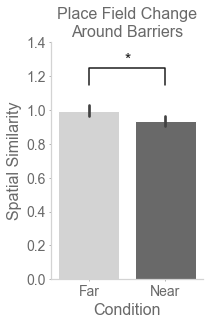

In [271]:
fig, ax = plt.subplots(figsize=(6.4*0.5, 4.8))
df = pd.DataFrame({'Spatial Similarity': corrs, 'Condition': condn})
sns.barplot(
    x='Condition', y='Spatial Similarity', data=df, ax=ax,
    palette=['lightgrey', 'dimgray']
    )

bar_top = 1.0
fig_dy = 0.4
sigbar_dy1 = 0.15
sigbar_dy2 = 0.25
plt.ylim(0, bar_top + fig_dy)
plt.plot(
   [0, 0, 1, 1],
   [bar_top+sigbar_dy1, bar_top+sigbar_dy2,
   bar_top+sigbar_dy2, bar_top+sigbar_dy1],
   lw=1.5, c='k')
plt.text((0+1)/2, bar_top+sigbar_dy2, "*", ha='center', va='bottom', color='k')

plt.xlabel('Condition', fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.ylabel('Spatial Similarity', fontsize=16)
plt.title('Place Field Change\nAround Barriers')
plt.tight_layout()
plt.savefig('5d_barrier_ranksums.png', dpi=300)
plt.show()

In [254]:
from scipy.stats import ranksums
ranksums(corrs[condn=='Far'], corrs[condn=='Near'])

RanksumsResult(statistic=2.539347847743099, pvalue=0.011105934082651146)

# Make Plots

In [255]:
walk_xs = barrier_dset.xs
walk_ys = barrier_dset.ys
arena_length = int(np.sqrt(barrier_dset.num_states))

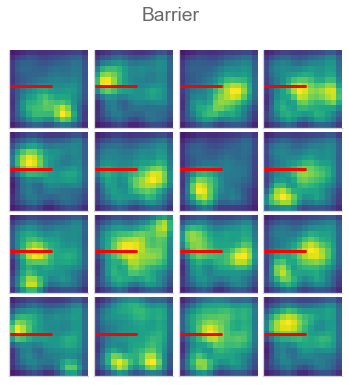

In [272]:
import matplotlib.gridspec as gridspec

grid_x = 4; grid_y = 4;

plt.figure(figsize = (6, 6))
gs1 = gridspec.GridSpec(grid_x, grid_y)
gs1.update(wspace=0.05, hspace=0.05) # set the spacing between axes. 

neurs = np.array(barrier_neurs)
np.random.shuffle(neurs)

idx = 0
for neur in neurs:
    firing_field, _ = get_firing_field(
        barrier_xs, barrier_ys, barrier_outputs[:, neur],
        arena_length
        )
    
#     firing_field = np.zeros((arena_length, arena_length))*np.nan
#     for x in range(arena_length):
#         for y in range(arena_length):
#             frame_idxs = np.logical_and(barrier_xs == x, barrier_ys == y)
#             fr = np.nanmean(barrier_outputs[frame_idxs, neur])
#             firing_field[x,y] = fr
#     firing_field[np.isnan(firing_field)] = 0    
#     if not np.any(firing_field > 0): continue
        
    ax = plt.subplot(gs1[idx])
    plt.axis('on')
    ax.imshow(firing_field/firing_field.max(), vmin=0, vmax=1, cmap='viridis')
    ax.plot([-0.5, arena_length/2], [arena_length//2 -1, arena_length//2 -1], 'red', linewidth=3)
    ax.set_xticks([])
    ax.set_yticks([])
    
    idx += 1
    if idx == grid_x*grid_y: break
plt.suptitle('Barrier')
plt.savefig('5d_barriers.png', dpi=300)
plt.show()

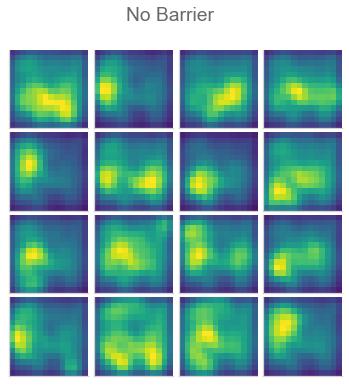

In [273]:
import matplotlib.gridspec as gridspec

grid_x = 4; grid_y = 4;

plt.figure(figsize = (6, 6))
gs1 = gridspec.GridSpec(grid_x, grid_y)
gs1.update(wspace=0.05, hspace=0.05) # set the spacing between axes. 

idx = 0
for neur in neurs:
    firing_field, _ = get_firing_field(
        reg_xs, reg_ys, reg_outputs[:, neur],
        arena_length
        )
    
#     firing_field = np.zeros((arena_length, arena_length))*np.nan
#     for x in range(arena_length):
#         for y in range(arena_length):
#             frame_idxs = np.logical_and(reg_xs == x, reg_ys == y)
#             fr = np.nanmean(reg_outputs[frame_idxs, neur])
#             firing_field[x,y] = fr
#     firing_field[np.isnan(firing_field)] = 0
    
    if not np.any(firing_field > 0): continue
    ax = plt.subplot(gs1[idx])
    plt.axis('on')
    ax.imshow(firing_field/firing_field.max(), vmin=0, vmax=1, cmap='viridis')
    ax.set_xticks([])
    ax.set_yticks([])
    
    idx += 1
    if idx == grid_x*grid_y: break
plt.suptitle('No Barrier')
plt.savefig('5d_no_barriers.png', dpi=300)
plt.show()